## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
# 從網路即時下載CIFAR10⼩圖像，數據集涵蓋50,000張32x32彩⾊色訓練圖像及10,000張測試圖像，並且標註超過10個類別
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 查詢檔案維度資訊
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step
Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000, 1)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)


In [0]:
# 資料前處理
def preproc_x(x):
    x = x.reshape((len(x), -1)) / 255.
    return x

def preproc_y(y, num_classes=10):
    from keras.utils import to_categorical

    y = to_categorical(y, num_classes)
    return y    

In [3]:
# 將資料從圖形 (RGB) 轉為向量 (Single Vector) 並進行標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")


# 將目標轉為 one-hot encoding
y_train = preproc_y(y_train, num_classes=10)
y_test = preproc_y(y_test, num_classes=10)
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (50000, 3072)
Shape of x_test: (10000, 3072)
Shape of y_train: (50000, 10)
Shape of y_test: (10000, 10)


In [0]:
from keras.layers import BatchNormalization
from keras import layers, models

def build_model(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    model = models.Sequential()
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            # 第一層
            model.add(layers.Dense(n_units, activation='relu', input_shape=(input_shape)))
            model.add(BatchNormalization())
        else:
            # 後續幾層
            model.add(layers.Dense(n_units, activation='relu'))
            model.add(BatchNormalization())

    # 最後一層
    model.add(layers.Dense(output_units, activation='softmax'))
    return model

In [0]:
# 超參數設定
learning_rate = 1e-3
epochs = 50
batch_size = 256
momentum = 0.95

In [0]:
import keras
from keras.callbacks import ReduceLROnPlateau

optimizer_set = {'SGD':keras.optimizers.SGD,
                 'Adam':keras.optimizers.Adam,
                 'RMSprop':keras.optimizers.RMSprop}

reduce_lr_factor = [0.1, 0.5, 0.7]
redice_lr_patient = [5, 10, 15]

In [7]:
import itertools

results = {}

for i, ((optim_name, optim), reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set.items(), reduce_lr_factor, redice_lr_patient)):
    # Release some memories
    keras.backend.clear_session()

    model = build_model(input_shape=x_train.shape[1:], output_units=10, num_neurons=[512, 256, 128])

    print(f"Experiment with optimizer = {optim_name}, reduce_lr_factor = {reduce_factor}, reduce_lr_patient={reduce_patient}")
    model.compile(optimizer=optim(lr=learning_rate),
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])

    history = model.fit(x_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(x_test, y_test), 
                        shuffle=True,
                        verbose=0)
    
    # Collect results  
    exp_tag = f"Experiment with optimizer = {optim_name}, reduce_lr_factor = {reduce_factor}, reduce_lr_patient={reduce_patient}"
    results[exp_tag] = {'train-loss': history.history["loss"],
                        'valid-loss': history.history["val_loss"],
                        'train-acc': history.history["acc"],
                        'valid-acc': history.history["val_acc"]}

    i += 1






Experiment with optimizer = SGD, reduce_lr_factor = 0.1, reduce_lr_patient=5


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Experiment with optimizer = SGD, reduce_lr_factor = 0.1, reduce_lr_patient=10
Experiment with optimizer = SGD, reduce_lr_factor = 0.1, reduce_lr_patient=15
Experiment with optimizer = SGD, reduce_lr_factor = 0.5, reduce_lr_patient=5
Experiment with optimizer = SGD, reduce_lr_factor = 0.5, reduce_lr_patient=10
Experiment with optimizer = SGD, reduce_lr_factor = 0.5, reduce_lr_patient=15
Experiment with optimizer = SGD, reduce_lr_factor = 0.7, reduce_lr_patient=5
Experiment with optimizer = SGD, reduce_lr_factor = 0.7, reduce_lr_patient=10
Experiment with optimizer = SGD, reduce_lr_factor = 0.7, reduce_lr_patient=15
Experiment with optimizer = Adam, reduce_lr_factor = 0.1, reduce_lr_patient=5
Experiment with optimizer = Adam, reduce_lr_factor = 0.1, reduce_lr_patient=10
Experiment with optimizer = Adam, r

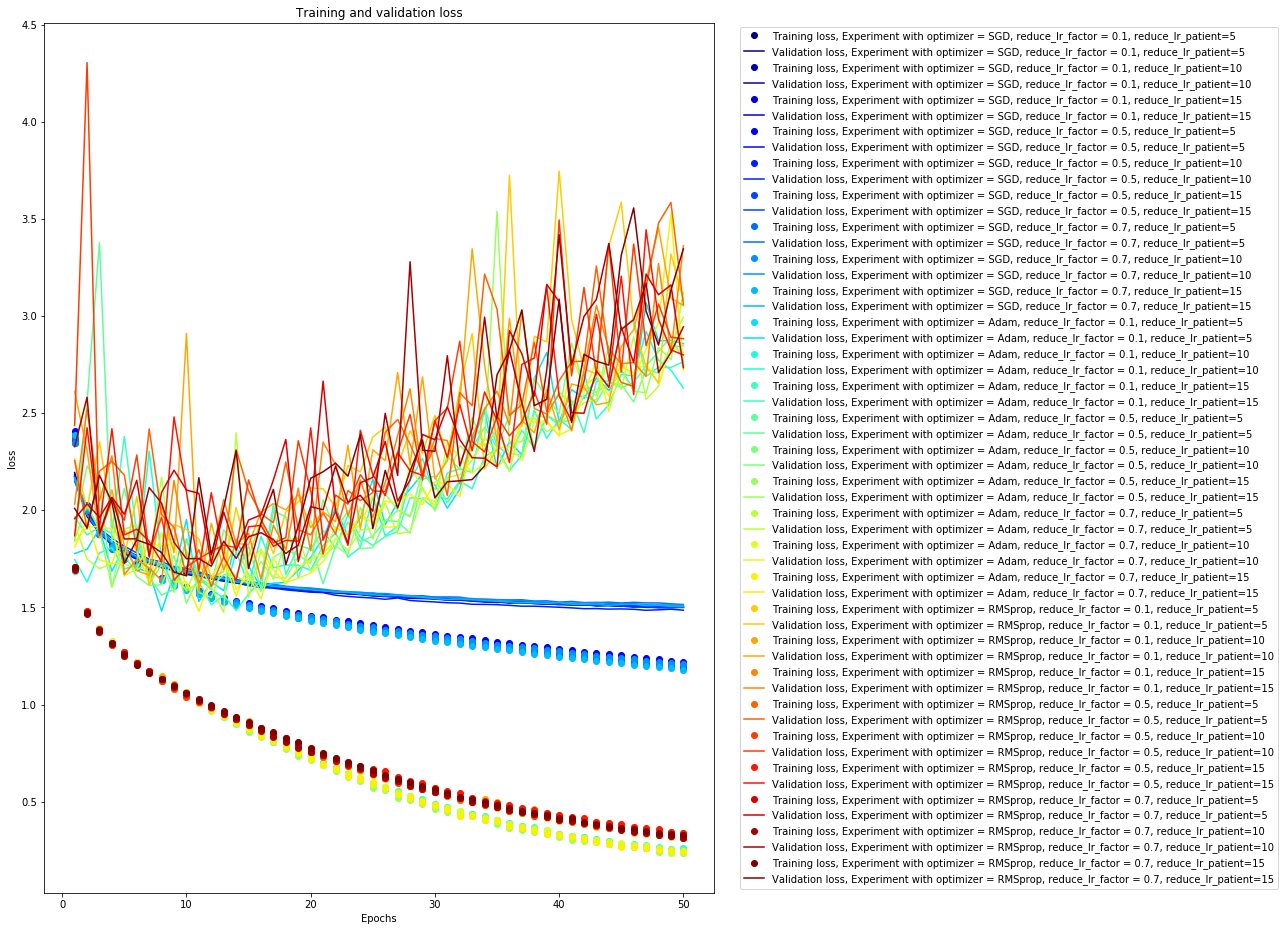

In [20]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

number_of_lines= len(results.keys())
cm_subsection = np.linspace(0, 1, number_of_lines) 
color_bar = [cm.jet(x) for x in cm_subsection]

plt.figure(figsize=(12,16))
for color, tg in zip(color_bar, results.keys()):
    plt.plot(range(1, epochs+1), results[tg]['train-loss'], 'o', label=f"Training loss, {tg}", color=color)
    plt.plot(range(1, epochs+1), results[tg]['valid-loss'], '-', label=f"Validation loss, {tg}", color=color)
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend(loc='right', bbox_to_anchor=(1.85, 0.5))

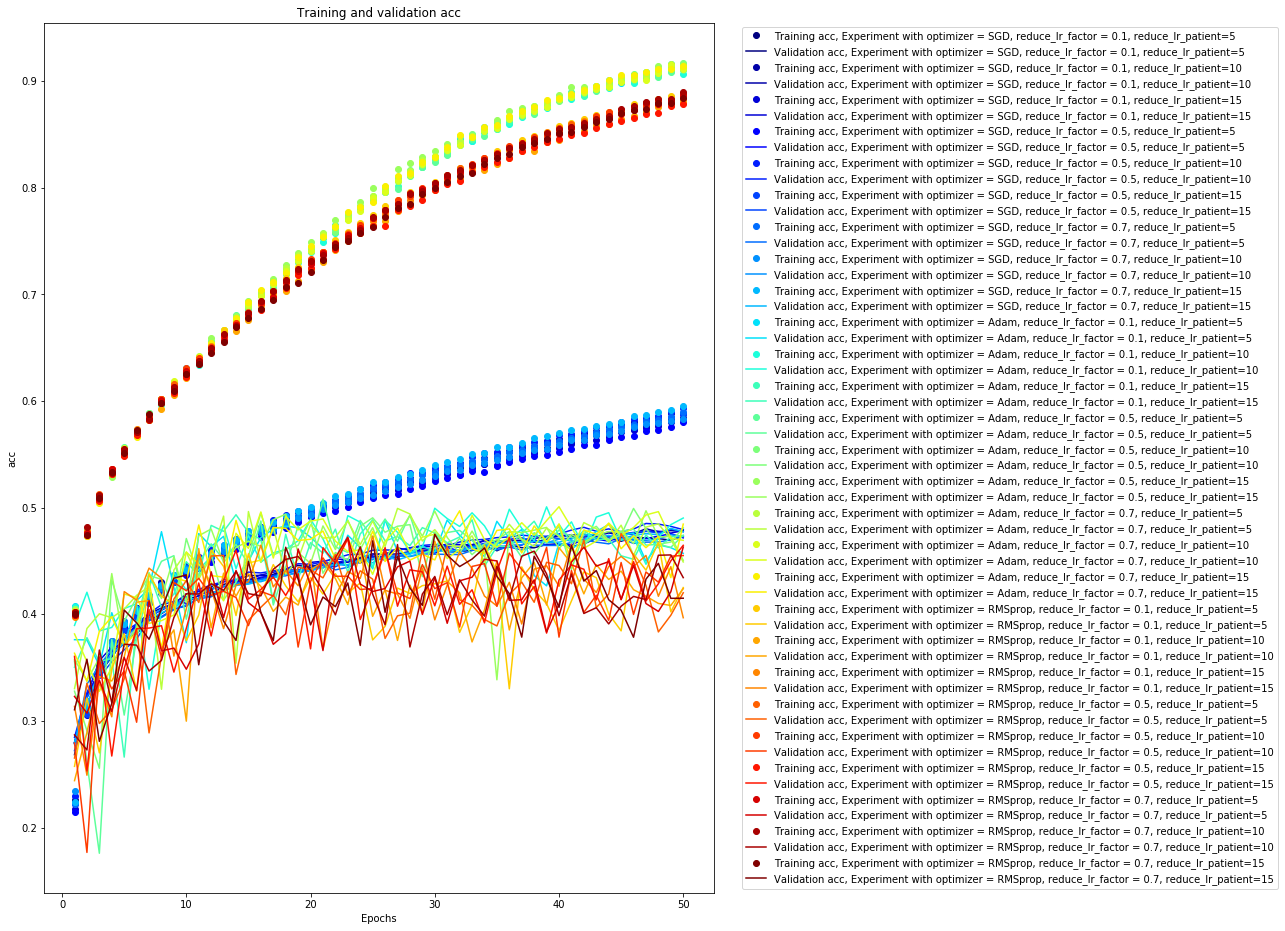

In [19]:
plt.figure(figsize=(12,16))
for color, tg in zip(color_bar, results.keys()):
    plt.plot(range(1, epochs+1), results[tg]['train-acc'], 'o', label=f"Training acc, {tg}", color=color)
    plt.plot(range(1, epochs+1), results[tg]['valid-acc'], '-', label=f"Validation acc, {tg}", color=color)
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('acc')
    plt.legend(loc='right', bbox_to_anchor=(1.85, 0.5))